# Regresión lineal con statsmodel (simple y múltiple)

En este notebook veremos la sintaxis del módulo statsmodel para realizar un regresor lineal, al igual que hicimos con el objeto de sklearn. Además, vamos a aportar algún concepto más para enriquecer nuestros análisis.

In [80]:
import pandas as pd
import numpy as np

In [81]:
data = pd.read_csv("data/Advertising.csv")

In [82]:
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


La sintaxis es muy similar a R, si alguno estáis familizarizado con ese programa, donde el el parámetro ``formula`` se le pasa la relación que se está buscando, utilizando el símbolo virgulilla (``~``) como elemento para identificar qué relación quiero buscar, que en este caso comenzará siendo una relación lineal simple entre las ventas y la inversión en TV:

In [83]:
import statsmodels.formula.api as smf

In [84]:
lm = smf.ols(formula="Sales~TV", data = data).fit()

Una vez definido, podemos obtener los parámetros calculados:

In [85]:
lm.params

Intercept    7.032594
TV           0.047537
dtype: float64

Aplicando estos parámetros a la definición, obtenemos la siguiente ecuación para modelizar nuestros datos en base al modelo que acabamos de definir:

$Sales = 7.032594 + 0.047537 * TV$

Para verificar que está todo bien, vamos a comprobar que los p-valores son netamente inferiores al umbral de 0.05. Cuanto menor sean mejor para el modelo:

In [86]:
lm.pvalues

Intercept    1.406300e-35
TV           1.467390e-42
dtype: float64

Como podemos comprobar, son muy muy bajos, por lo que en este aspecto podemos estar tranquilos, estos parámetros son suficientemente significativos, por lo que no van a ser 0.

Por otra parte, también podemos medir la eficacia del modelo. En este caso, lo haremos a través del R-cuadrado:

In [87]:
lm.rsquared

0.611875050850071

En el caso de que empecemos a introducir más y más variables, R-cuadrado se queda un poco atrás, siendo más realista el cálculo del parámetro R-cuadrado ajustado, que añade una corrección del valor R-cuadrado en base al número de variables de entrada:

In [88]:
lm.rsquared_adj

0.6099148238341623

Finalmente, imprimimos las características más importantes:

In [89]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sat, 23 Jan 2021   Prob (F-statistic):           1.47e-42
Time:                        04:50:12   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

Muy bonito pero... ¿Qué nos interesa de aquí? Pues muchas cosas.

De la tabla anterior nos nteresan, sobre todo:
1. R-squared y/o Adj. R-squared: parámetro para medir el rendimiento del modelo
2. P-valores de las columnas: deben estar por debajo de cierto umbral (0.05) para asegurar que las variables aporten valor
3. Relacionada con 2: que en el rango de valores entre los que puede estar una variable no incluya el 0
4. Valor F-statistic: cuanto mayor sea este parámetro, y cuanto más pequeño sea Prob(F-static), mejor para el desemepño del modelo
5. Parámetros AIC y BIC (Criterio de Información de Akake y Bayesiano) deben ser lo mayores posible

Pasemos ahora a realizar predicciones:

In [90]:
sales_pred = lm.predict(pd.DataFrame(data["TV"]))
sales_pred

0      17.970775
1       9.147974
2       7.850224
3      14.234395
4      15.627218
         ...    
195     8.848493
196    11.510545
197    15.446579
198    20.513985
199    18.065848
Length: 200, dtype: float64

In [91]:
import matplotlib.pyplot as plt

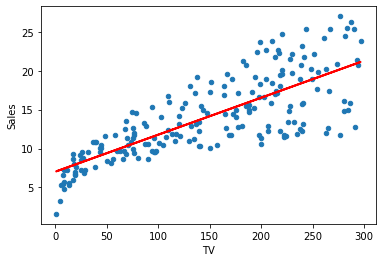

In [92]:
# Representamos:
%matplotlib inline
data.plot(kind = "scatter", x = "TV", y ="Sales")
plt.plot(pd.DataFrame(data["TV"]), sales_pred, c="red", linewidth = 2)

Añadimos al dataset una columna con las predicciones para poder trabajar más fácil con ellas:

In [93]:
data["sales_pred"] = 7.032594 + 0.047537*data["TV"]

Y calculamos los errores residuales para cada punto (RSE):

In [94]:
data["RSE"] = (data["Sales"]-data["sales_pred"])**2

Con estos, podemos calcular cosas como el error cuadrático residual (Residual Squared Error, RSE), que nos ayudará a calcular la suma de los cuadrados de la diferencia:

In [95]:
SSD = sum(data["RSE"])
SSD

2102.5305838896525

Con lo que podré obtener la desviación típica de los residuos (RSE):

In [96]:
RSE = np.sqrt(SSD/(len(data)-2))
RSE

3.258656369238098

Y calcular el error promedio, es decir, podré obtener cuánto porcentaje de la varianza del modelo me va a quedar sin explicar:

In [97]:
sales_m = np.mean(data["Sales"])

In [98]:
sales_m

14.022500000000003

In [99]:
error = RSE/sales_m

In [100]:
error

0.2323876890168014

Nos queda sin explicar aproximadamente un 23% de la varianza totoal del modelo.

Representamos los errores residuales para asegurarnos de que siguen una distribución más o menos normal:

(array([ 4., 10., 13., 17., 40., 42., 33., 16., 17.,  8.]),
 array([-8.3860819 , -6.82624404, -5.26640618, -3.70656832, -2.14673046,
        -0.5868926 ,  0.97294526,  2.53278312,  4.09262098,  5.65245884,
         7.2122967 ]),
 <a list of 10 Patch objects>)

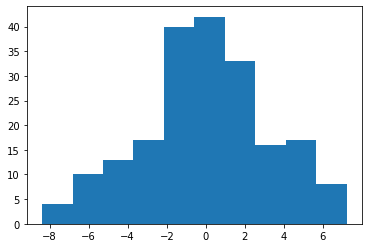

In [208]:
plt.hist((data["Sales"]-data["sales_pred"]))

## Regresión lineal múltiple

En esta segunda parte del notebook, vamos a analizar cómo se comportan los modelos si añadimos el resto de variables, y qué técnicas tener en cuenta para elegir un método u otro. Para ello, probaremos las ($2^k-1$) combinaciones posibles, con ``k = nº máximo de variables de entrada``:

* Sales ~TV
* Sales ~Newspaper
* Sales ~Radio
* Sales ~TV+Newspaper
* Sales ~TV+Radio
* Sales ~Newspaper+Radio
* Sales ~TV+Newspaper+Radio

In [102]:
# Empezamos con el modelo en el que añadimos la varaible "Newspapaer" al TV.
lm2 = smf.ols(formula="Sales~TV+Newspaper", data = data).fit()

In [103]:
lm2.params

Intercept    5.774948
TV           0.046901
Newspaper    0.044219
dtype: float64

In [104]:
lm2.pvalues # Nos fijamos que ninguno de ellos esté superando el umbral

Intercept    3.145860e-22
TV           5.507584e-44
Newspaper    2.217084e-05
dtype: float64

$Sales = 5.774948+0.046901*TV + 0.044219*Newspaper$

In [105]:
# Medimos rendimiento:
lm2.rsquared

0.6458354938293271

In [106]:
lm2.rsquared_adj

0.6422399150864777

In [107]:
# Pese a que no sean valores muy elevados, tampoco son malos y parece difícil que podamos mejorar estas marcas. Por lo tanto, pasamos a predecir:
sales_pred = lm2.predict(data[["TV", "Newspaper"]])

In [108]:
sales_pred

0      19.626901
1       9.856348
2       9.646055
3      15.467318
4      16.837102
         ...    
195     8.176802
196    10.551220
197    14.359467
198    22.003458
199    17.045429
Length: 200, dtype: float64

Obtenemos el porcentaje de la varianza que no somos capaces de explicar:

In [109]:
SSD = sum((data["Sales"]-sales_pred)**2)

In [110]:
SSD

1918.561811896827

In [111]:
RSE = np.sqrt(SSD/(len(data)-2-1))

In [112]:
RSE

3.120719860252885

In [113]:
error = RSE / sales_m

In [114]:
error

0.22255089037282116

In [115]:
# Resumimos características:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     179.6
Date:                Sat, 23 Jan 2021   Prob (F-statistic):           3.95e-45
Time:                        04:50:17   Log-Likelihood:                -509.89
No. Observations:                 200   AIC:                             1026.
Df Residuals:                     197   BIC:                             1036.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7749      0.525     10.993      0.000       4.739       6.811
TV             0.0469      0.003     18.173      0.000       0.042       0.052
Newspaper      0.0442      0.010      4.346      0.000       0.024       0.064
==============================================================================
Omnibus:                        0.658   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.720   Jarque-Bera (JB):                0.415
Skew:                          -0.093   Prob(JB):                        0.813
Kurtosis:                       3.122   Cond. No.                         410.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
# Añadimos la Radio al modelo de la TV solitaria:
lm3 = smf.ols(formula="Sales~TV+Radio", data = data).fit()

In [117]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Sat, 23 Jan 2021   Prob (F-statistic):           4.83e-98
Time:                        04:50:17   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
Radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
sales_pred = lm3.predict(data[["TV", "Radio"]])
SSD = sum((data["Sales"]-sales_pred)**2)
RSE = np.sqrt(SSD/(len(data)-2-1))

In [119]:
RSE

1.6813609125080013

In [120]:
RSE/sales_m

0.11990450436855062

A diferencia del caso anterior, aquí se puede observar que el modelo mejora notablemente, por lo que sí sería interesante añadir la variable "radio" al modelo final.

Continuamos evaluando el modelo que nos queda:

In [121]:
# Añadimos todo:
lm4 = smf.ols(formula="Sales~TV+Radio+Newspaper", data = data).fit()

In [122]:
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 23 Jan 2021   Prob (F-statistic):           1.58e-96
Time:                        04:50:18   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
sales_pred = lm4.predict(data[["TV", "Radio","Newspaper"]])
SSD = sum((data["Sales"]-sales_pred)**2)
RSE = np.sqrt(SSD/(len(data)-3-1))

In [124]:
RSE

1.6855103734147439

In [125]:
RSE/sales_m

0.12020041885646236

Como puedes observar, con este último modelo, en el que se ha añadido una variable más que en el anterior, se obtienen resultados incluso peores (menor varianza explicada). Si nos fijamos en el rango de posibles valores de ``Newspaper``, vemos que incluye el 0, lo cual nos hace sospechar. Además, al estar asociado a un p-valor superior al umbral, ya nos hace suponer que su valor será prácticamente 0, por lo que no aportará información para la predicción. Además, el valor de F baja considerablemente. Resumen: añadir el periódico me empeora el modelo.


Esto puede ser debido a varios factores, como podría ser el caso de la multicolinealidad, que no es más ni menos que el fenómeno de que una variable predictora (de las X) esté correlacionada (en un nivel suficientemente significativo) con otra variable predictora.

Veamos si es lo que ocurre en este momento:

## Multicolinealidad 

Para evaluar la multicolinealidad, nos basaremos en un indicador llamado Factor de Inflación de la Varianza (VIF), que nos indicará si existe cierta relación entre un par de variables, valorando la opción de eliminar alguna de ellas del modelo:
#### Factor Inflación de la Varianza
* VIF = 1 : Las variables no están correlacionadas
* 1 < VIF < 5 : Las variables tienen una correlación moderada y se pueden quedar en el modelo
* VIF > 5 : Las variables están altamente correlacionadas y deben desaparecer del modelo.

Para calcular este parámetro nos basaremos en el R-cuadrado, ya que su fórmula viene definida por la sigueinte ecuación:


$VIF = \frac{1}{1-R^{2}}$

Pero ¡OJO!, que en este caso no hemos dicho de qué tenemos que calcular el R-cuadrado, lo hay que hacer de cada uno de los modelos que podamos crear con una varaible expresada en función del resto. De este modo, podremos comprobar si existe cierta correlación entre la variabe a predecir en cada caso con el resto:

In [202]:
# Newspaper ~ TV + Radio -> R^2 VIF = 1/(1-R^2)
lm_n = smf.ols(formula="Newspaper~TV+Radio", data = data).fit()
rsquared_n = lm_n.rsquared
VIF = 1/(1-rsquared_n)
VIF

1.145187378723929

In [203]:
# TV ~ Newspaper + Radio -> R^2 VIF = 1/(1-R^2)
lm_tv = smf.ols(formula="TV~Newspaper+Radio", data=data).fit()
rsquared_tv = lm_tv.rsquared
VIF = 1/(1-rsquared_tv)
VIF

1.0046107849396502

In [204]:
# Radio ~ TV + Newspaper -> R^2 VIF = 1/(1-R^2)
lm_r = smf.ols(formula="Radio~Newspaper+TV", data=data).fit()
rsquared_r = lm_r.rsquared
VIF = 1/(1-rsquared_r)
VIF

1.1449519171055353

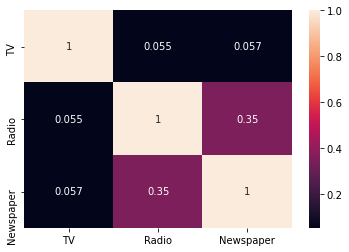

In [205]:
import seaborn as sns
sns.heatmap(data[['TV', 'Radio', 'Newspaper']].corr(), annot=True);

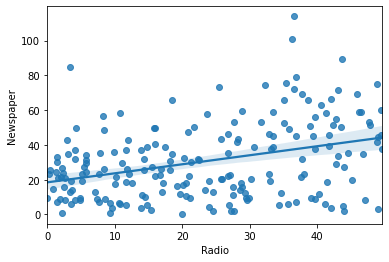

In [216]:
sns.regplot(x=data['Radio'], y=data['Newspaper'])

Como hemos podido observar, hemos obtenido un valor muy próximo a 1 al evaluar ``TV``, por lo que está muy claro que esa variable no se relaciona con ninguna otra. Esto es bueno.

Por otra parte, observamos que las otras 2 variables nos devuelven VIFs relativamente pequeños también, lo que hace que no podamos inferir que una explica una gran parte de la varianza de la otra, pese a que estén ligeramente correlacionadas.

Sin embargo, dado que el modelo con las 3 variables daba resultados semejantes a los obtenidos al que utilizaba únicamente TV y Radio, que a su vez daba mejores resultados que el de TV y Newspaper, nos quedamos con el modelo 3 (Sales=TV+Radio)

In [217]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Sat, 23 Jan 2021   Prob (F-statistic):           4.83e-98
Time:                        05:20:26   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
Radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### EJERCICIO

1. Lee el dataframe de los coches y busca el modelo de regresión lineal que mejor se adapte a la predicción de mpg. Para ello, prueba diferentes combinaciones de lo que acabamos de ver. *Tip: Prueba a ir paso a paso*
2. Una vez tengas un modelo que creas que es bueno, separa en train y test, siguiendo un 70-30%. En este caso, vamos a poner todos un seed igual a 42 para poder probar todos con lo mismo. A ver quién saca el mejor modelo y cuántos coincidimos. Para hacer esta separación, utiliza la función de sklear (train_test_split). ¿Cómo puedes pasarle ahora el dataframe de entrenamiento al statsmodel?

Para calcular el R-squared y comparar los modelos, podemos utilizar el código que tienes un par de líneas más abajo, donde ``y_test`` será el array con los valores de test del target, e ``y_pred`` serán las predicciones para X_test.

3. Repite el mismo procedimiento para predecir ``hp``

In [258]:
df = pd.read_csv("../../../data/coches.csv")
df.dtypes

model     object
mpg      float64
cyl        int64
disp     float64
hp         int64
drat     float64
wt       float64
qsec     float64
vs         int64
am         int64
gear       int64
carb       int64
dtype: object

In [256]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.869597643245784